<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment3/Assignment3HumanActivityRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<html><h1><center style="color:blue">Human Activity Recognition with Smartphones</center></h1></html>

# Load in Libraries

In [1]:
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap

!python -m pip install 'fsspec>=0.3.3'
import tracemalloc
import pandas as pd
import dask.dataframe as dd
import time

from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import homogeneity_score, completeness_score, \
v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
%matplotlib inline

pd.set_option('display.max_rows', None)

     |████████████████████████████████| 134 kB 5.5 MB/s 


# Read in Files

Upload zip UCI HAR Dataset.zip

In [2]:
!unzip "UCI HAR Dataset.zip"

Archive:  UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating: UCI HAR

In [3]:
# get the features from the file features.txt
features = list()
with open('UCI HAR Dataset/features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]
print('No of Features: {}'.format(len(features)))

No of Features: 561


In [573]:
# get the features from the file features.txt
features = list()
with open('UCI HAR Dataset/features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]
print('No of Features: {}'.format(len(features)))

# get the data from txt files to pandas dataffame
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
X_train.columns = [features]
# add subject column to the dataframe
X_train['subject'] = pd.read_csv('UCI HAR Dataset/train/subject_train.txt', header=None, squeeze=True)

y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', names=['Activity'], squeeze=True)
y_train_labels = y_train.map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',\
                       4:'SITTING', 5:'STANDING',6:'LAYING'})

# put all columns in a single dataframe
train = X_train
train['Activity'] = y_train
train['ActivityName'] = y_train_labels

No of Features: 561


In [576]:
# get the data from txt files to pandas dataffame
# /content/UCI HAR Dataset/test/X_test.txt
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)
X_test.columns = [features]
# add subject column to the dataframe
X_test['subject'] = pd.read_csv('UCI HAR Dataset/test/subject_test.txt', header=None, squeeze=True)

# get y labels from the txt file
y_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt', names=['Activity'], squeeze=True)
y_test_labels = y_test.map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',\
                       4:'SITTING', 5:'STANDING',6:'LAYING'})


# put all columns in a single dataframe
test = X_test
test['Activity'] = y_test
test['ActivityName'] = y_test_labels
test.sample(2)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
1505,0.325086,-0.083458,-0.069686,-0.226714,-0.001029,-0.442841,-0.244126,-0.025467,-0.404585,-0.022844,...,-0.312017,0.800818,0.942260,-0.487479,-0.737955,0.278947,0.027828,12,2,WALKING_UPSTAIRS
1155,0.417146,-0.012465,-0.142213,-0.043340,-0.133504,-0.410114,-0.133404,-0.164355,-0.446275,0.174388,...,-0.728549,0.851096,0.008263,-0.533100,-0.909459,0.044622,-0.022294,10,1,WALKING


In [580]:
df = pd.concat([test, train])

In [581]:
print('Shape of the data set: ' + str(df.shape))

Shape of the data set: (10299, 564)


# Data Exploration

### 1. Check for Duplicates

In [582]:
print('No of duplicates in train: {}'.format(sum(df.duplicated())))

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:208: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


No of duplicates in train: 0


### 2. Checking for NaN/null values

In [583]:
print('We have {} NaN/Null values in train'.format(df.isnull().values.sum()))

We have 0 NaN/Null values in train


In [584]:
df.to_csv('df.csv', index=False)
df = pd.read_csv('df.csv')

In [589]:
columns = df.columns

# Removing '()' from column names
columns = columns.str.replace('[()]','')
columns = columns.str.replace('[-]', '')
columns = columns.str.replace('[,]','')

df.columns = columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


Activity per Subject

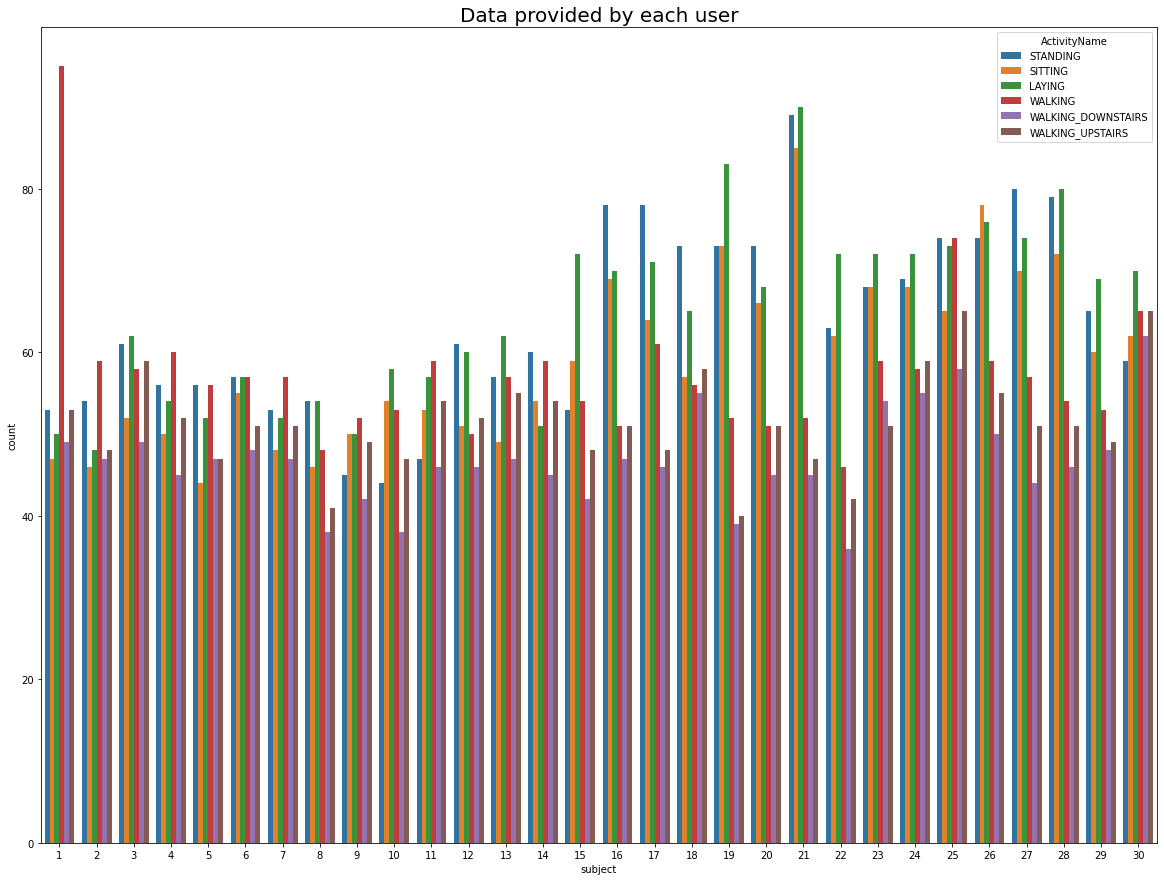

In [590]:
plt.figure(figsize=(20,15))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='subject',hue='ActivityName', data = df)
plt.show()

Activity Count

Text(0.5, 1.0, 'Count per Activity')

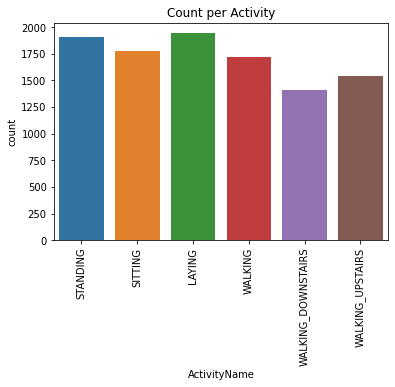

In [591]:
sns.countplot(x ='ActivityName', data = df)
plt.xticks(rotation=90)
plt.title("Count per Activity")

Moving vs Stationary Activities

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

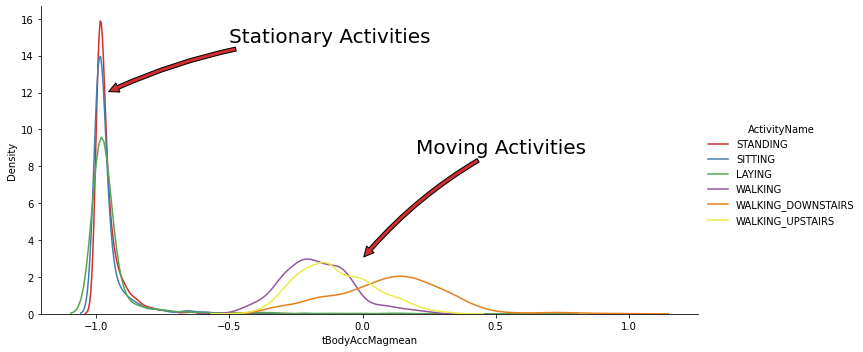

In [596]:
sns.set_palette("Set1", desat=0.80)
facetgrid = sns.FacetGrid(df, hue='ActivityName', height=5,aspect=2)
facetgrid.map(sns.distplot,'tBodyAccMagmean', hist=False)\
    .add_legend()
plt.annotate("Stationary Activities", xy=(-0.960,12), xytext=(-0.5, 15), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))

plt.annotate("Moving Activities", xy=(0,3), xytext=(0.2, 9), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))
plt.show()

# Feature Selection

In [597]:
print(df.shape)

(10299, 564)


In [598]:
features = df.drop(['subject','ActivityName'], axis=1)

In [599]:
from sklearn.feature_selection import SelectKBest, f_regression
def select_k_best(train_data,k):
  train_data = train_data.apply(pd.to_numeric).astype('float32')

  kb = SelectKBest(score_func=f_regression, k=k)
  kb.fit(train_data.loc[:, train_data.columns != 'Activity'], train_data.Activity)
  indices = np.argsort(kb.scores_)[::-1]
  selected_features = []
  for i in range(k):
    selected_features.append(train_data.columns[indices[i]])
  return selected_features

In [600]:
k_no_features = 200
selected_features_k_best = select_k_best(features,k_no_features)

In [601]:
features_names_df = pd.DataFrame(list(features.columns),columns =['featureNames'])

In [602]:
print(features_names_df.head())

    featureNames
0  tBodyAccmeanX
1  tBodyAccmeanY
2  tBodyAccmeanZ
3   tBodyAccstdX
4   tBodyAccstdY


Takes time as computing silohette score for 560 features

In [603]:
features_selected = features[selected_features_k_best].copy()

In [604]:
print(features_selected.shape)

(10299, 200)


# Pre-processing

In [605]:
X_train = features_selected 
y_train_6_classes = df['Activity']
y_train_6_classes_labels = df['ActivityName']

In [606]:
conditions_2_classes = [(df['Activity'] <= 3),(df['Activity'] > 3)]
values_2_classes = [0, 1]
y_train_2_classes = np.select(conditions_2_classes, values_2_classes)

In [607]:
conditions_2_classes_labels = [(y_train_2_classes == 0),(y_train_2_classes == 1)]
values_2_classes_labels = ["MOTION","STATIONARY",]
y_train_2_classes_labels = np.select(conditions_2_classes_labels, values_2_classes_labels)

In [608]:
#normalize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Metrics

In [609]:
def get_dbscan_metrics(targets, c_labels,name):
  evaluation_results = []
  n_clusters_ = len(set(c_labels)) - (1 if -1 in c_labels else 0)
  evaluation_results.append(n_clusters_)
  evaluation_results.append(metrics.homogeneity_score(targets, c_labels))
  evaluation_results.append(metrics.completeness_score(targets, c_labels))
  evaluation_results.append(metrics.v_measure_score(targets, c_labels))
  evaluation_results.append(metrics.adjusted_rand_score(targets,c_labels))
  evaluation_results.append(metrics.adjusted_mutual_info_score(targets, c_labels))
  evaluation_results = [ '%.2f' % elem for elem in evaluation_results]
  evaluation_results.insert(0, name)
  return evaluation_results

In [610]:
from prettytable import PrettyTable
def print_metrics(evaluation_results):
  labels = ['name','no_clusters', 'homo','compl','v-meas','ARI','AMI']
  results = evaluation_results  
  t = PrettyTable(labels)
  t.add_row(results)
  return t

In [611]:
# Plot the clusters
def plot_dbscan_cluster(ax,title,dataframe,labels):
  ax.scatter(dataframe[:, 0], dataframe[:,1], c = labels, cmap= "plasma") 
  ax.title.set_text(title)
  ax.set_xlabel("Component 1")
  ax.set_ylabel("Component 2")

In [612]:
def visualise_labels(dataframe,targets,colors):
  import matplotlib.pyplot as plt
  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1) 
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title('2 component PCA', fontsize = 20)
  
  for target, color in zip(targets,colors):
      indicesToKeep = dataframe['ActivityName'] == target
      ax.scatter(dataframe.loc[indicesToKeep, 'principal component 1']
                , dataframe.loc[indicesToKeep, 'principal component 2']
                , c = color
                , s = 50)
  ax.legend(targets)
  ax.grid()

In [613]:
def get_optimal_epislon(start,end,min_points,dataframe,targets):
    high_score = 0
    optimal_epsilon = 0
    for epsilon_current in range(start, end):
        # print("episilon current:  " + str(epsilon_current))
        labels = getDbscan(epsilon_current, min_points, dataframe)
        score = metrics.homogeneity_score(targets, labels)
        # print("episilon current score:  " + str(score))
        if score >= high_score:
            optimal_epsilon = epsilon_current
            high_score = score
    return optimal_epsilon

In [614]:
def plot_cluster(ax,graph_title,dataframe,target_names,colors,labels):
  # Supply the limits since random data will be plotted
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title(graph_title, fontsize = 20)

  for target, color in zip(target_names,colors):
      indicesToKeep = labels == target
      ax.scatter(dataframe.loc[indicesToKeep, 'principal component 1']
                , dataframe.loc[indicesToKeep, 'principal component 2']
                , c = color
                , s = 50)
  ax.legend(target_names)
  ax.grid()

# DBSCAN

In [37]:
def getDbscan(eps, min_samples, data_frame):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(data_frame)
    dbscan.fit(data_frame)
    c_labels = dbscan.labels_
    return c_labels

In [489]:
def findDBSCANOptimalEpsilon(features,ns):
  noOfPointsYouHave = len(features)
  nbrs = NearestNeighbors(n_neighbors=ns).fit(features)
  distances, indices = nbrs.kneighbors(features)
  distanceDec = sorted(distances[:,ns-1], reverse=True)
  plt.figure(figsize=(20,10))
  plt.title("Nearest Neighbours Distance Graph")
  plt.plot(list(range(1,noOfPointsYouHave+1)), distanceDec)

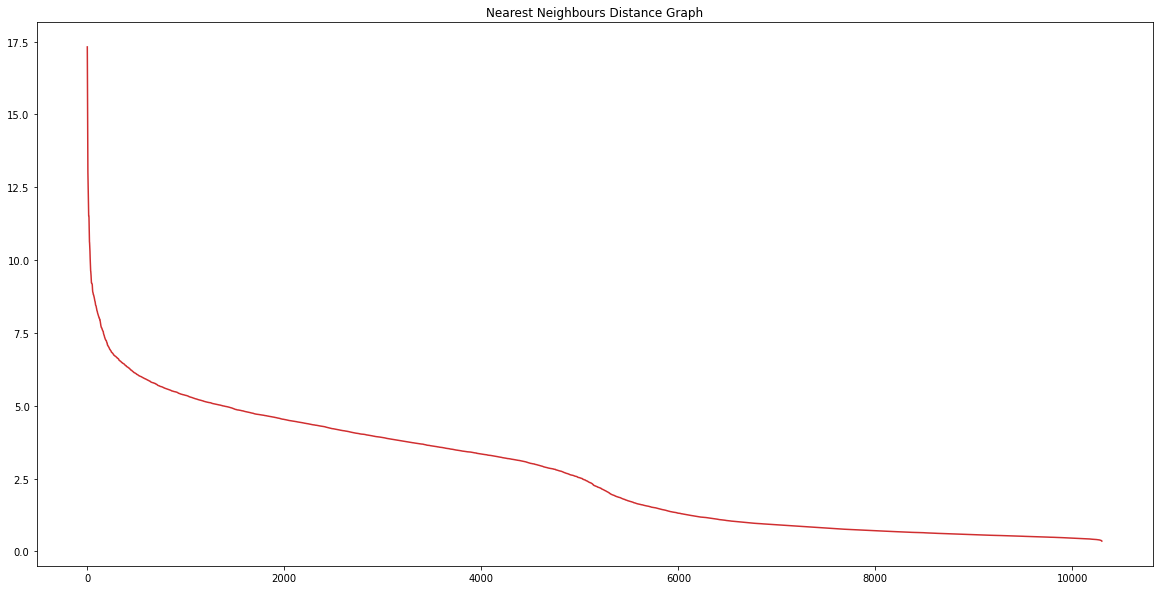

In [615]:
findDBSCANOptimalEpsilon(X_train,6)

Parameter picking min_points_normal:
minPts is selected based on the domain knowledge. If you do not have domain understanding, a rule of thumb is to derive minPts from the number of dimensions D in the data set. minPts >= D + 1. For 2D data, take minPts = 4. For larger datasets, with much noise, it suggested to go with minPts = 2 * D.

In [662]:
number_of_features_normal = X_train.shape[1]
min_points_normal_start = number_of_features_normal + 1
min_points_normal_end = 2*number_of_features_normal

In [664]:
print("suggested min points is between :  " + str(min_points_normal_start) +
      "  and " + str(min_points_normal_end))

suggested min points is between :  201  and 400


Parameter picking epsilon

In [665]:
epsilon_normal_2_classes = 5
cluster_labels_normal_2_classes = getDbscan(epsilon_normal_2_classes,201, X_train)
evaluation_metrics_normal_2_classes  = get_dbscan_metrics(y_train_2_classes,cluster_labels_normal_2_classes,'PLAIN_2_CLUSTERS')
print(print_metrics(evaluation_metrics_normal_2_classes))

+------------------+-------------+------+-------+--------+------+------+
|       name       | no_clusters | homo | compl | v-meas | ARI  | AMI  |
+------------------+-------------+------+-------+--------+------+------+
| PLAIN_2_CLUSTERS |     2.00    | 0.94 |  0.66 |  0.77  | 0.79 | 0.77 |
+------------------+-------------+------+-------+--------+------+------+


In [668]:
epsilon_normal_6_classes = 4
cluster_labels_normal_6_classes = getDbscan(epsilon_normal_6_classes, 34, X_train)
evaluation_metrics_normal_6_classes  = get_dbscan_metrics(y_train_6_classes,cluster_labels_normal_6_classes,'PLAIN_6_CLUSTERS')
print(print_metrics(evaluation_metrics_normal_6_classes))

+------------------+-------------+------+-------+--------+------+------+
|       name       | no_clusters | homo | compl | v-meas | ARI  | AMI  |
+------------------+-------------+------+-------+--------+------+------+
| PLAIN_6_CLUSTERS |     6.00    | 0.38 |  0.66 |  0.49  | 0.31 | 0.49 |
+------------------+-------------+------+-------+--------+------+------+


# PCA

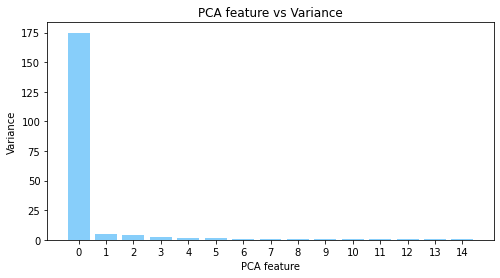

In [633]:
#check for optimal number of features
pca = PCA(random_state=123)
pca.fit(X_train)
features = range(pca.n_components_)

plt.figure(figsize=(8,4))
plt.bar(features[:15], pca.explained_variance_[:15], color='lightskyblue')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.title('PCA feature vs Variance')
plt.xticks(features[:15])
plt.show()

In [496]:
def pca_transform(n_comp,data):
    pca = PCA(n_components=n_comp, random_state=123)
    dataReduced = pca.fit_transform(data)
    print('Shape of the new Data df: ' + str(dataReduced.shape))
    return dataReduced

In [634]:
X_train_pca = pca_transform(n_comp=2, data=X_train)

Shape of the new Data df: (10299, 2)


In [660]:
number_of_features_pca = X_train_pca.shape[1]
min_points_pca_start = 1+ number_of_features_pca
min_points_pca_end = 2*number_of_features_pca

In [661]:
print("suggested min points is between:  " + str(min_points_pca_start) + " and " 
      + str(min_points_pca_end))

suggested min points is between:  3 and 4


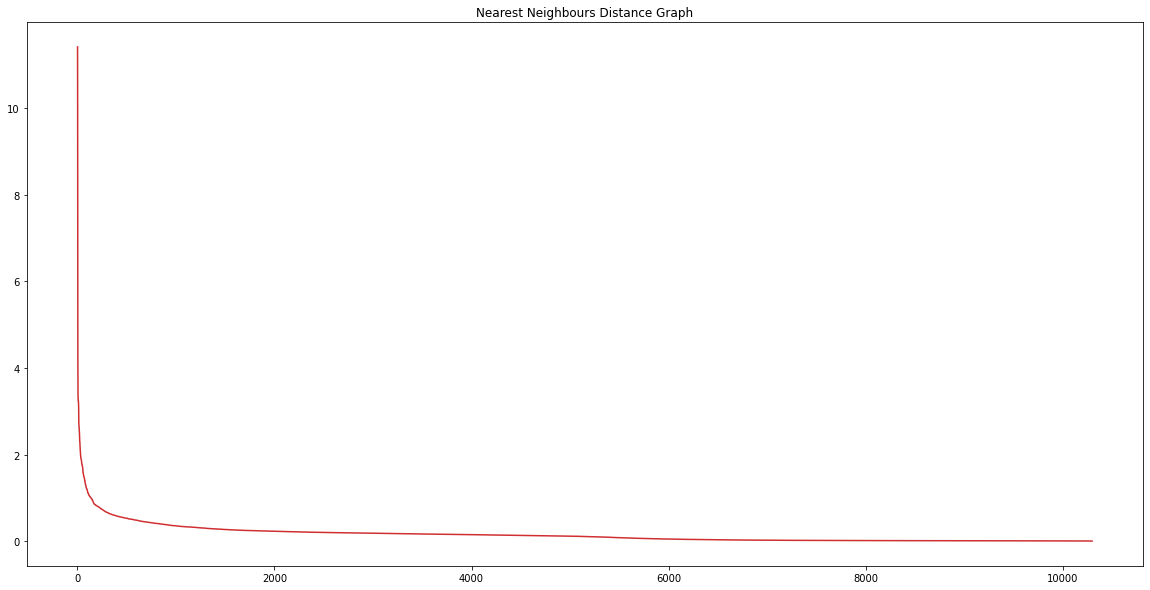

In [637]:
findDBSCANOptimalEpsilon(X_train_pca,6)

In [646]:
epsilon_pca_6_classes = 1
cluster_labels_pca_6_classes = getDbscan(epsilon_pca_6_classes, 3, X_train_pca)
evaluation_metrics_pca_6_classes  = get_dbscan_metrics(y_train_6_classes,cluster_labels_pca_6_classes,'PCA_6_CLASSES')
print(print_metrics(evaluation_metrics_pca_6_classes))

+---------------+-------------+------+-------+--------+------+------+
|      name     | no_clusters | homo | compl | v-meas | ARI  | AMI  |
+---------------+-------------+------+-------+--------+------+------+
| PCA_6_CLASSES |     6.00    | 0.38 |  0.94 |  0.54  | 0.33 | 0.54 |
+---------------+-------------+------+-------+--------+------+------+


In [658]:
epsilon_pca_2_classes = 1
cluster_labels_pca_2_classes = getDbscan(epsilon_pca_2_classes, 8, X_train_pca)
evaluation_metrics_pca_2_classes = get_dbscan_metrics(y_train_2_classes,cluster_labels_pca_2_classes,'PCA_2_CLASSES')
print(print_metrics(evaluation_metrics_pca_2_classes))

+---------------+-------------+------+-------+--------+------+------+
|      name     | no_clusters | homo | compl | v-meas | ARI  | AMI  |
+---------------+-------------+------+-------+--------+------+------+
| PCA_2_CLASSES |     2.00    | 0.98 |  0.91 |  0.95  | 0.98 | 0.95 |
+---------------+-------------+------+-------+--------+------+------+


# Evaluation Computational




Computer efficieny methods

In [669]:
# The first function is to stop the tracing, if any, and to start the fresh tracing. 
# This ensures that the tracing of 2 code blocks doesn’t interfere with each other. 
def tracing_start():
    tracemalloc.stop()
    print("nTracing Status : ", tracemalloc.is_tracing())
    tracemalloc.start()
    print("Tracing Status : ", tracemalloc.is_tracing())

# The second function is to find the peak size in MB of a block of code that was traced.
def tracing_mem():
    first_size, first_peak = tracemalloc.get_traced_memory()
    peak = first_peak/(1024*1024)
    print("peak in MB:  " + str(peak))
    return peak

In [670]:
# PCA
tracing_start()
start = time.time()
getDbscan(epsilon_pca_6_classes, min_points_pca, X_train_pca)
end = time.time()
pca_time = (end-start)*1000
print("time elapsed PCA {} milli seconds".format(pca_time))
pca_peak = tracing_mem()

# normal
tracing_start()
start = time.time()
getDbscan(epsilon_normal_6_classes, min_points_normal, X_train)
end = time.time()
normal_time = (end-start)*1000
print("time elapsed normal {} milli seconds".format(normal_time))
normal_peak = tracing_mem()

nTracing Status :  False
Tracing Status :  True
time elapsed PCA 648.0817794799805 milli seconds
peak in MB:  2.8383359909057617
nTracing Status :  False
Tracing Status :  True
time elapsed normal 5369.816064834595 milli seconds
peak in MB:  988.4376173019409


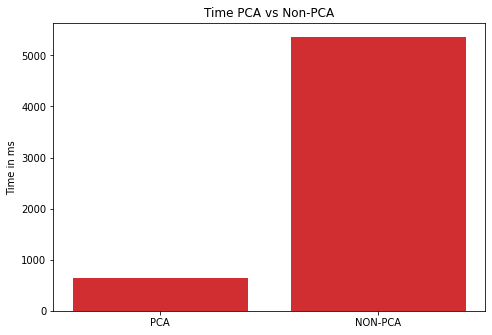

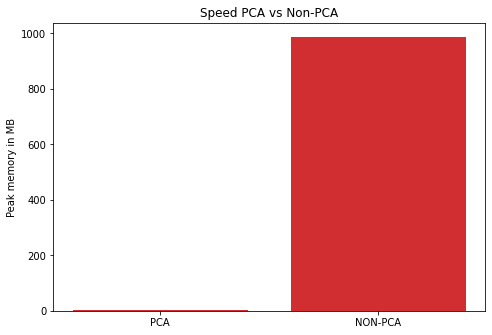

In [671]:
# Plot time
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['PCA','NON-PCA']
times_miliseconds = [pca_time,normal_time]
ax.bar(labels,times_miliseconds)
plt.ylabel("Time in ms")
plt.title("Time PCA vs Non-PCA")
plt.show()

# Plot speed
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['PCA','NON-PCA']
peak_MB = [pca_peak,normal_peak]
ax.bar(labels,peak_MB)
plt.ylabel("Peak memory in MB")
plt.title("Speed PCA vs Non-PCA")
plt.show()

In [672]:
pca_time = '%.2f' % pca_time
normal_time = '%.2f' % normal_time
pca_peak =  '%.2f' % pca_peak
normal_peak =  '%.2f' % normal_peak

labels = ['name','times_miliseconds', 'peak_memory']
pca_computational = ['pca',pca_time,pca_peak]
normal_computational = ['normal',normal_time,normal_peak]

t_computational = PrettyTable(labels)
t_computational.add_row(pca_computational)
t_computational.add_row(normal_computational)
print(t_computational)

+--------+-------------------+-------------+
|  name  | times_miliseconds | peak_memory |
+--------+-------------------+-------------+
|  pca   |       648.08      |     2.84    |
| normal |      5369.82      |    988.44   |
+--------+-------------------+-------------+


In [673]:
print(pca_time)

648.08


# Evaluation Clustering

Evaluation Clustering metrics Table

In [674]:
t = print_metrics(evaluation_metrics_normal_6_classes)
t.add_row(evaluation_metrics_pca_6_classes)
t.add_row(evaluation_metrics_normal_2_classes)
t.add_row(evaluation_metrics_pca_2_classes)
print(t)

+------------------+-------------+------+-------+--------+------+------+
|       name       | no_clusters | homo | compl | v-meas | ARI  | AMI  |
+------------------+-------------+------+-------+--------+------+------+
| PLAIN_6_CLUSTERS |     6.00    | 0.38 |  0.66 |  0.49  | 0.31 | 0.49 |
|  PCA_6_CLASSES   |     6.00    | 0.38 |  0.94 |  0.54  | 0.33 | 0.54 |
| PLAIN_2_CLUSTERS |     2.00    | 0.94 |  0.66 |  0.77  | 0.79 | 0.77 |
|  PCA_2_CLASSES   |     2.00    | 0.98 |  0.91 |  0.95  | 0.98 | 0.95 |
+------------------+-------------+------+-------+--------+------+------+


Plot 6 Class Clusters

In [675]:
targets_names_6_classes = [-1, 0,  1,  2,  3,  4,  5]
targets_names_6_classes_labels = targets_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS',
           'SITTING','STANDING','LAYING']
colors_6_classes = ['r', 'g', 'b','m','c','y','k']

df = pd.DataFrame(data = X_train_pca
             , columns = ['principal component 1', 'principal component 2'])

In [676]:
print(np.unique(cluster_labels_pca_2_classes))

[-1  0  1]


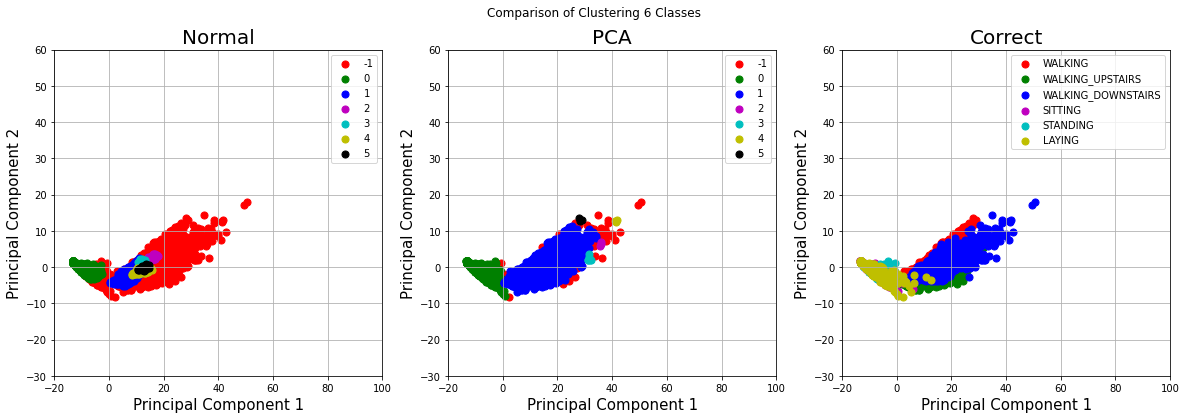

In [677]:
# both use pca for visual comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,6))
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (-20, 100)
custom_ylim = (-30, 60)

# # Setting the values for all axes.
plt.setp(ax1, xlim=custom_xlim, ylim=custom_ylim)
plt.setp(ax2, xlim=custom_xlim, ylim=custom_ylim)
plt.setp(ax3, xlim=custom_xlim, ylim=custom_ylim)

fig.suptitle('Comparison of Clustering 6 Classes')
plot_cluster(ax1,"Normal", df,targets_names_6_classes, colors_6_classes,cluster_labels_normal_6_classes)
plot_cluster(ax2,"PCA", df,targets_names_6_classes, colors_6_classes,cluster_labels_pca_6_classes)
plot_cluster(ax3,"Correct", df,targets_names_6_classes_labels,colors_6_classes,y_train_6_classes_labels)

Plot 2 Class Clusters

In [678]:
targets_names_2_classes = [-1, 0,  1]
targets_names_2_classes_labels = values_2_classes_labels
colors_2_classes = ['r', 'g', 'k']

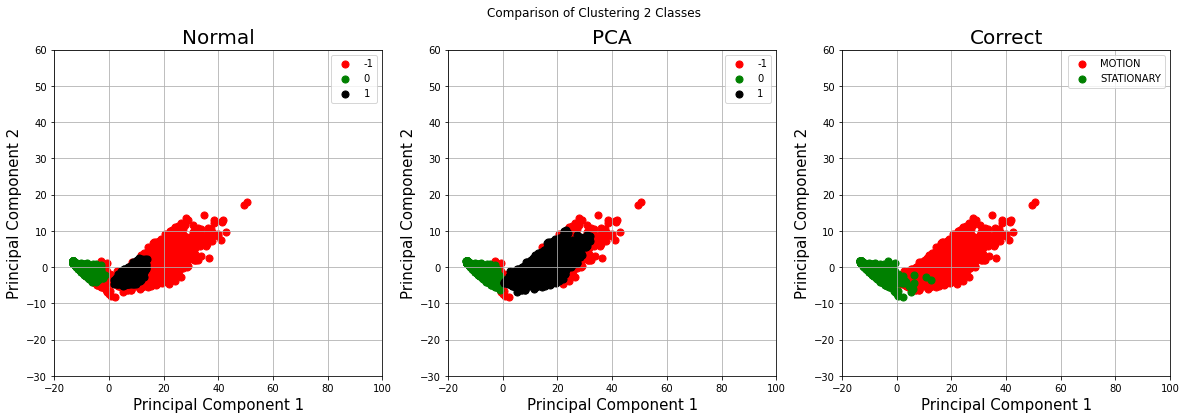

In [679]:
custom_xlim = (-20, 100)
custom_ylim = (-30, 60)

# both use pca for visual comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,6))

# # Setting the values for all axes.
plt.setp(ax1, xlim=custom_xlim, ylim=custom_ylim)
plt.setp(ax2, xlim=custom_xlim, ylim=custom_ylim)
plt.setp(ax3, xlim=custom_xlim, ylim=custom_ylim)

fig.suptitle('Comparison of Clustering 2 Classes')
plot_cluster(ax1,"Normal", df,targets_names_2_classes, colors_2_classes,cluster_labels_normal_2_classes)
plot_cluster(ax2,"PCA", df,targets_names_2_classes, colors_2_classes,cluster_labels_pca_2_classes)
plot_cluster(ax3,"Correct", df,targets_names_2_classes_labels,colors_2_classes,y_train_2_classes_labels)